In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 2.- Ejemplo: Algoritmos de Aprendizaje por Refuerzo


* En este notebook vamos a resolver un problema con Aprendizaje por refuerzo usando los algoritmos del Q-Learning y SARSA-Learning.


* El problema que queremos resolver es el de encontrar el camino que nos suponga una mayor recompensa (el más corto) desde un estado inicial $[0,0]$ hasta el estado final $[4,4]$, pudiendo realizar 4 tipos de acciones:


<img src="./imgs/007_RL.png" style="width: 300px;"/>



* Para resolver este problema vamos a realizar lo siguiente:
<span></span><br>
    1. [Definición del entorno](#M1)
<span></span><br>
    2. [Implementación de un algoritmo de toma aleatoria de acciones](#M2)
<span></span><br>
    3. [Ejecución: Entorno - Agente](#M3)
<span></span><br>
    4. [Q-Learner: Implementación y Ejecución](#M4)
<span></span><br>
    5. [SARSA-Learner: Implementación y Ejecución](#M5)
<span></span><br>
    6. [Estrategias a corto y largo plazo](#M5)


<hr>


## <a name="M1">1.- Definición del entorno</a>






In [2]:
# importamos las librerias necesarias
import pandas as pd
import numpy as np

# Formato de los decimales en Pandas y la semilla del Random
pd.options.display.float_format = '{:,.2f}'.format
np.random.seed(5)


class Environment(object):
    def __init__(self, action_penalty=-1.0):
        """
        Clase que representa y controla en entorno
        :param step_penalty:    Factor de descuento del Reward por acción tomada
        """
        self.actions = {'Arriba': [-1, 0],
                        'Abajo': [1, 0],
                        'Izquierda': [0, -1],
                        'Derecha': [0, 1]}
        self.rewards = [[0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, -100.0, 100.0]]
        self.action_penalty = action_penalty         # Penalización por cada paso dado
        self.state = [0, 0]                          # Estado en el que se encuentra el agente
        self.final_state = [3, 3]                    # Estado final del entorno. Cuando el agente llega, se termina el episodio
        self.total_reward = 0.0                      # Contador de recompensas en el episodio
        self.actions_done = []                       # Lista en la que se guardan los pasos (acciones) realizadas en cada episodio

    def reset(self):
        """
        Método que reinicia las variables del entorno y devuelve es estado inicial
        :return:    state
        """
        self.total_reward = 0.0    # Inicializamos Reward a 0
        self.state = [0, 0]        # Posicionamos al agente en el estado inicial
        self.actions_done = []     # Inicializamos la listas de pasos (acciones)
        return self.state

    def step(self, action):
        """
        Método que ejecuta una acción determinada del conjunto de acciones {Arriba, Abajo, Izquierda, Derecha}
        para guiar al agente en el entorno.
        :param action:    Acción a ejecutar
        :return:          (state, reward, is_final_state)
        """
        self.__apply_action(action)                                                # Realizamos la acción (cambio de estado)
        self.actions_done.append(self.state[:])                                    # Guardamos el paso (accion) realizada
        is_final_state = np.array_equal(self.state, self.final_state)              # Comprobamos si hemos llegado al estado final
        reward = self.rewards[self.state[0]][self.state[1]] + self.action_penalty  # Calculamos el reward (recompensa) por la acción tomada
        self.total_reward += reward                                                # Sumamos el reward (recompensa) total del episodio
        return self.state, reward, is_final_state                                  # Devolvemos es estado, el reward (recompensa) y si hemos llegado al estado final

    def __apply_action(self, action):
        """
        Método que calcula el nuevo estado a partir de la acción a ejecutar
        :param action:    Acción a ejecutar
        """
        self.state[0] += self.actions[action][0]
        self.state[1] += self.actions[action][1]

        # Si nos salimos del tablero por arriba o por abajo, nos quedamos en la posicion que estabamos
        if self.state[0] < 0:
            self.state[0] = 0
        elif self.state[0] > len(self.rewards) - 1:
            self.state[0] -= 1

        # Si nos salimos del tablero por los lados, nos quedamos en la posicion que estabamos
        if self.state[1] < 0:
            self.state[1] = 0
        elif self.state[1] > len(self.rewards[0]) - 1:
            self.state[1] -= 1

    def print_path_episode(self):
        """
        Método que imprime por pantalla el camino seguido por el agente
        :return: 
        """
        path = [['-' for _ in range(len(self.rewards))] for _ in range(len(self.rewards[0]))]
        path[0][0] = '0'
        for index, step in enumerate(self.actions_done):
            path[step[0]][step[1]] = str(index + 1)

        print(pd.DataFrame(data=np.array([np.array(xi) for xi in path]),
                           index=["x{}".format(str(i)) for i in range(len(path))],
                           columns=["y{}".format(str(i)) for i in range(len(path[0]))]))


<hr>


## <a name="M2">2.- Implementación de un algoritmo de toma aleatoria de acciones</a>




In [3]:
class Learner(object):

    def __init__(self, environment, learning_rate=0.1, discount_factor=0.1, ratio_exploration=0.05):
        """
        Clase que implementa un algoritmo de aprendiza por refuerzo
        Esta clase implementa un algoritmo de selección aleatoria de acciones
        :param environment:         Entorno en el que tomar las acciones
        :param learning_rate:       Factor de aprendizaje
        :param discount_factor:     Factor de descuento (0=Estrategia a corto plazo, 1=Estrategia a largo plazo)
        :param ratio_exploration:   Ratio de exploración
        """
        self.environment = environment
        self.q_table = [[[0.0 for _ in self.environment.actions]
                         for _ in range(len(self.environment.rewards))]
                        for _ in range(len(self.environment.rewards[0]))]
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.ratio_exploration = ratio_exploration

    @property
    def name(self):
        return 'random'

    def get_next_action(self, state):
        """
        Método que selecciona la siguiente acción a tomar:
            Aleatoria -> si el ratio de exploración es inferior al umbral
            Mejor Acción -> si el ratio de exploración es superior al umbral
        :param state:   Estado del agente
        :return:        next_action
        """

        if np.random.uniform() < self.ratio_exploration:
            # Seleccionamos una opción al azar
            next_action = np.random.choice(list(self.environment.actions))
        else:
            # Seleccionamos la acción que nos de mayor valor. Si hay empate, Seleccionamos una al azar
            idx_action = np.random.choice(np.flatnonzero(
                self.q_table[state[0]][state[1]] == np.array(self.q_table[state[0]][state[1]]).max()
            ))
            next_action = list(self.environment.actions)[idx_action]

        return next_action

    def update(self, **kwargs):
        """
        Actualiza la Q-Table
        :param kwargs: 
        """
        pass

    def print_q_table(self):
        """
        Método que imprime por pantalla la Q-Table
        """
        q_table = []
        for x, row in enumerate(self.q_table):
            for y, col in enumerate(row):
                q = deepcopy(col)
                q.insert(0, 'x{},y{}'.format(x,y))
                q_table.append(q)
        print(pd.DataFrame(data=q_table,
                           columns=['Estado', 'Arriba', 'Abajo', 'Izquierda', 'Derecha'])
              .to_string(index=False))

    def print_best_values_states(self):
        """
        Método que imprime por pantalla el valor de la mejor opción a realizar en cada uno de los estados
        """
        best = [[max(vi) for vi in row] for row in self.q_table]
        print(pd.DataFrame(data=np.array([np.array(xi) for xi in best]),
                           index=["x{}".format(str(i)) for i in range(len(best))],
                           columns=["y{}".format(str(i)) for i in range(len(best[0]))]))


<hr>


## <a name="M3">3.- Ejecución: Entorno - Agente</a>




In [4]:
from copy import deepcopy


def run_agent(learner=Learner, num_episodes=10, learning_rate=0.1, discount_factor=0.1, ratio_exploration=0.05,
              verbose=False):
    """
    Método que ejecuta el proceso de aprendizaje del agente en un entorno
    :param learner:              Algoritmo de Aprendizaje
    :param num_episodes:         Número de veces que se ejecuta (o aprende) el agente en el entorno
    :param learning_rate:        Factor de Aprendizaje
    :param discount_factor:      Factor de descuento (0=Estrategia a corto plazo, 1=Estrategia a largo plazo)
    :param ratio_exploration:    Ratio de exploración
    :param verbose:              Boolean, si queremos o no imprimir por pantalla información del proceso
    :return:                     (episodes_list, best_episode)
    """

    # Instanciamos el entorno
    environment = Environment()

    # Instanciamos el método de aprendizaje
    learner = learner(environment=environment,
                      learning_rate=learning_rate,
                      discount_factor=discount_factor,
                      ratio_exploration=ratio_exploration)

    # Variables para guardar la información de los episodios
    episodes_list = []
    best_reward = float('-inf')
    best_episode = None

    for n_episode in range(0, num_episodes):
        state = environment.reset()
        reward = None
        is_final_state = None
        num_steps_episode = 0
        while not is_final_state:
            old_state = state[:]
            next_action = learner.get_next_action(state=state)               # Accion a realizar; bien sea explotando la Q-Table o explorando
            state, reward, is_final_state = environment.step(next_action)    # Realizamos la accion
            next_post_action = (learner.get_next_action(state)               # Si usamos el SARSA realizamos una accion en el nuevo estado S_t+1
                                if learner.name == 'SARSA' else None)
            learner.update(environment=environment,                          # Actualizamos el entorno
                           old_state=old_state,
                           action_taken=next_action,
                           reward_action_taken=reward,
                           new_state=state,
                           new_action=next_post_action,
                           is_final_state=is_final_state)
            num_steps_episode += 1                                           # Sumamos un paso al episocio

        episodes_list.append([n_episode + 1,                                 # Guardamos la información del episodio
                              num_steps_episode, 
                              environment.total_reward])

        # Guardamos el mejor episodio
        if environment.total_reward >= best_reward:
            best_reward = environment.total_reward
            best_episode = {'num_episode': n_episode + 1,
                            'episode': deepcopy(environment),
                            'learner': deepcopy(learner)}

        if verbose:
            # Imprimimos la información de los episodios
            print('EPISODIO {} - Numero de acciones: {} - Reward: {}'
                  .format(n_episode + 1, num_steps_episode, environment.total_reward))

    return episodes_list, best_episode


def print_process_info(episodes_list, best_episode, print_best_episode_info=True,
                       print_q_table=True, print_best_values_states=True,
                       print_steps=True, print_path=True):
    """
    Método que imprime por pantalla los resultados de la ejecución
    """
    if print_best_episode_info:
        print('\nMEJOR (ÚLTIMO) EPISODIO:\nEPISODIO {}\n\tNumero de acciones: {}\n\tReward: {}'
              .format(best_episode['num_episode'],
                      len(best_episode['episode'].actions_done),
                      best_episode['episode'].total_reward))

    if print_q_table:
        print('\nQ_TABLE:')
        best_episode['learner'].print_q_table()

    if print_best_values_states:
        print('\nBEST Q_TABLE VALUES:')
        best_episode['learner'].print_best_values_states()

    if print_steps:
        print('\nPasos: \n   {}'.format(best_episode['episode'].actions_done))

    if print_path:
        print('\nPATH:')
        best_episode['episode'].print_path_episode()


In [5]:
episodes_list, best_episode = run_agent(learner=Learner, 
                                        verbose=True)

print_process_info(episodes_list=episodes_list, 
                   best_episode=best_episode)

EPISODIO 1 - Numero de acciones: 91 - Reward: -391.0
EPISODIO 2 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 3 - Numero de acciones: 17 - Reward: -117.0
EPISODIO 4 - Numero de acciones: 60 - Reward: -360.0
EPISODIO 5 - Numero de acciones: 312 - Reward: -2012.0
EPISODIO 6 - Numero de acciones: 148 - Reward: -648.0
EPISODIO 7 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 8 - Numero de acciones: 216 - Reward: -616.0
EPISODIO 9 - Numero de acciones: 52 - Reward: 48.0
EPISODIO 10 - Numero de acciones: 45 - Reward: 55.0

MEJOR (ÚLTIMO) EPISODIO:
EPISODIO 7
	Numero de acciones: 19
	Reward: 81.0

Q_TABLE:
Estado  Arriba  Abajo  Izquierda  Derecha
 x0,y0    0.00   0.00       0.00     0.00
 x0,y1    0.00   0.00       0.00     0.00
 x0,y2    0.00   0.00       0.00     0.00
 x0,y3    0.00   0.00       0.00     0.00
 x1,y0    0.00   0.00       0.00     0.00
 x1,y1    0.00   0.00       0.00     0.00
 x1,y2    0.00   0.00       0.00     0.00
 x1,y3    0.00   0.00       0.00     0.00
 x2,y0    

<hr>


## <a name="M4">4.- Q-Learner: Implementación y Ejecución</a>


* Recordemos el Pseudocódigo del Algoritmo:


<img src="./imgs/013_qlearning.png" style="width: 600px;"/>


In [6]:
class QLearner(Learner):

    @property
    def name(self):
        return 'QLearner'

    def update(self, environment, old_state, action_taken, reward_action_taken, new_state, is_final_state, **kwargs):
        """
        Método que implementa el Algoritmo de aprendizaje del Q-Learning
        :param environment:           Entorno en el que tomar las acciones
        :param old_state:             Estado actual
        :param action_taken:          Acción a realizar
        :param reward_action_taken:   Recompensa obtenida por la acción tomada
        :param new_state:             Nuevo estado al que se mueve el agente
        :param is_final_state:        Boolean. Devuelve True si el agente llega al estado final; si no, False
        :param kwargs: 
        """
        # Obtengo el identificador de la acción
        idx_action_taken = list(environment.actions).index(action_taken)

        # Obtengo el valor de la acción tomada
        actual_q_value_options = self.q_table[old_state[0]][old_state[1]]
        actual_q_value = actual_q_value_options[idx_action_taken]

        future_q_value_options = self.q_table[new_state[0]][new_state[1]]
        future_max_q_value = reward_action_taken + self.discount_factor * max(future_q_value_options)
        if is_final_state:
            future_max_q_value = reward_action_taken    # Reward máximo si llego a la posición final

        self.q_table[old_state[0]][old_state[1]][idx_action_taken] = \
            actual_q_value + self.learning_rate * (future_max_q_value - actual_q_value)


#### Estrategia a corto plazo

In [7]:
episodes_list, best_episode = run_agent(learner=QLearner,
                                        num_episodes=25,
                                        learning_rate=0.1,
                                        discount_factor=0.1,
                                        ratio_exploration=0.05,
                                        verbose=True)

print_process_info(episodes_list=episodes_list,
                   best_episode=best_episode)


EPISODIO 1 - Numero de acciones: 41 - Reward: -41.0
EPISODIO 2 - Numero de acciones: 52 - Reward: -52.0
EPISODIO 3 - Numero de acciones: 29 - Reward: 71.0
EPISODIO 4 - Numero de acciones: 18 - Reward: 82.0
EPISODIO 5 - Numero de acciones: 35 - Reward: 65.0
EPISODIO 6 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 7 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 8 - Numero de acciones: 13 - Reward: 87.0
EPISODIO 9 - Numero de acciones: 43 - Reward: 57.0
EPISODIO 10 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 11 - Numero de acciones: 21 - Reward: -21.0
EPISODIO 12 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 13 - Numero de acciones: 24 - Reward: 76.0
EPISODIO 14 - Numero de acciones: 36 - Reward: 64.0
EPISODIO 15 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 16 - Numero de acciones: 41 - Reward: 59.0
EPISODIO 17 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 18 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 19 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 20 - Numero d

#### Estrategia a largo plazo

In [8]:
episodes_list, best_episode = run_agent(learner=QLearner,
                                        num_episodes=25,
                                        learning_rate=0.1,
                                        discount_factor=0.9,
                                        ratio_exploration=0.05,
                                        verbose=True)

print_process_info(episodes_list=episodes_list,
                   best_episode=best_episode)

EPISODIO 1 - Numero de acciones: 20 - Reward: -120.0
EPISODIO 2 - Numero de acciones: 41 - Reward: 59.0
EPISODIO 3 - Numero de acciones: 21 - Reward: 79.0
EPISODIO 4 - Numero de acciones: 54 - Reward: 46.0
EPISODIO 5 - Numero de acciones: 23 - Reward: 77.0
EPISODIO 6 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 7 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 8 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 9 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 10 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 11 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 12 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 13 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 14 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 15 - Numero de acciones: 13 - Reward: 87.0
EPISODIO 16 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 17 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 18 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 19 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 20 - Numero de ac

<hr>


## <a name="M5">5.- SARSA-Learner: Implementación y Ejecución</a>


* Recordemos el Pseudocódigo del Algoritmo:


<img src="./imgs/014_sarsa.png" style="width: 600px;"/>

In [9]:
class SARSALearner(Learner):

    @property
    def name(self):
        return 'SARSA'

    def update(self, environment, old_state, action_taken, reward_action_taken, new_state, new_action, is_final_state):
        """
        Método que implementa el algoritmo de aprendizaje SARSA
        :param environment:           Entorno en el que tomar las acciones
        :param old_state:             Estado actual
        :param action_taken:          Acción a realizar
        :param reward_action_taken:   Recompensa obtenida por la acción tomada
        :param new_state:             Nuevo estado al que se mueve el agente 
        :param new_action:            Acción a tomar en el nuevo estado
        :param is_final_state:        Boolean. Devuelve True si el agente llega al estado final; si no, False 
        """
        # Obtengo el identificador de la acción
        idx_action_taken = list(environment.actions).index(action_taken)

        # Obtengo el valor de la acción tomada
        actual_q_value_options = self.q_table[old_state[0]][old_state[1]]
        actual_q_value = actual_q_value_options[idx_action_taken]

        future_q_value_options = self.q_table[new_state[0]][new_state[1]]

        idx_new_action_taken = list(environment.actions).index(new_action)
        future_new_action_q_value = \
            reward_action_taken + self.discount_factor * future_q_value_options[idx_new_action_taken]
        if is_final_state:
            # Reward máximo si llego a la posición final
            future_new_action_q_value = reward_action_taken

        self.q_table[old_state[0]][old_state[1]][idx_action_taken] = \
            actual_q_value + self.learning_rate * (future_new_action_q_value - actual_q_value)


#### Estrategia a corto plazo

In [10]:
episodes_list, best_episode = run_agent(learner=SARSALearner,
                                        num_episodes=25,
                                        learning_rate=0.1,
                                        discount_factor=0.1,
                                        ratio_exploration=0.05,
                                        verbose=True)

print_process_info(episodes_list=episodes_list,
                   best_episode=best_episode)

EPISODIO 1 - Numero de acciones: 115 - Reward: -315.0
EPISODIO 2 - Numero de acciones: 28 - Reward: 72.0
EPISODIO 3 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 4 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 5 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 6 - Numero de acciones: 40 - Reward: 60.0
EPISODIO 7 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 8 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 9 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 10 - Numero de acciones: 50 - Reward: 50.0
EPISODIO 11 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 12 - Numero de acciones: 28 - Reward: 72.0
EPISODIO 13 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 14 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 15 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 16 - Numero de acciones: 50 - Reward: 50.0
EPISODIO 17 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 18 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 19 - Numero de acciones: 30 - Reward: 70.0
EPISODIO 20 - Numero

#### Estrategia a largo plazo

In [11]:
episodes_list, best_episode = run_agent(learner=SARSALearner,
                                        num_episodes=25,
                                        learning_rate=0.1,
                                        discount_factor=0.9,
                                        ratio_exploration=0.05,
                                        verbose=True)

print_process_info(episodes_list=episodes_list,
                   best_episode=best_episode)

EPISODIO 1 - Numero de acciones: 23 - Reward: -223.0
EPISODIO 2 - Numero de acciones: 34 - Reward: 66.0
EPISODIO 3 - Numero de acciones: 50 - Reward: 50.0
EPISODIO 4 - Numero de acciones: 35 - Reward: 65.0
EPISODIO 5 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 6 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 7 - Numero de acciones: 31 - Reward: 69.0
EPISODIO 8 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 9 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 10 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 11 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 12 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 13 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 14 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 15 - Numero de acciones: 9 - Reward: 91.0
EPISODIO 16 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 17 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 18 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 19 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 20 - Numero de acc

<hr>


## <a name="M6">6.- Estrategias a corto y largo plazo</a>


### Q-Learning

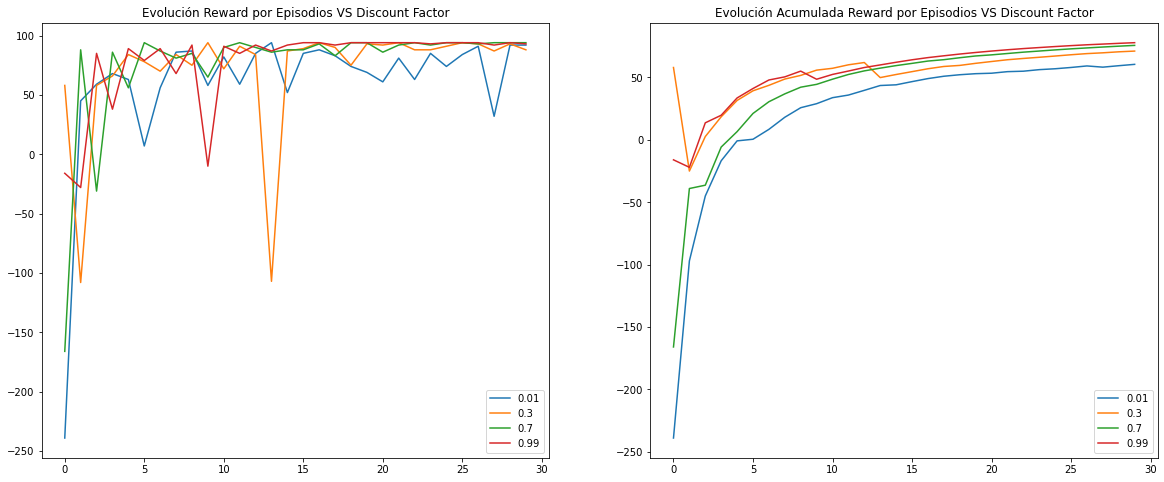

In [12]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

discount_factors = [0.01, 0.3, 0.7, 0.99]
experiments = []
for disfac in discount_factors:
    episodes_list, best_episode = run_agent(learner=QLearner,
                                            num_episodes=30,
                                            learning_rate=0.1,
                                            discount_factor=disfac,
                                            ratio_exploration=0.05)
    experiments.append({'Discount Factor': str(disfac),
                        'Rewards': [episode[2] for episode in episodes_list]})

plt.figure(figsize=(20, 8))
for experiment in experiments:
    plt.subplot(1, 2, 1)
    plt.title('Evolución Reward por Episodios VS Discount Factor')
    plt.plot(experiment['Rewards'], label=experiment['Discount Factor'])
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Evolución Acumulada Reward por Episodios VS Discount Factor')
    acum_avg_reward = (np.cumsum(experiment['Rewards']) / (np.arange(len(experiment['Rewards'])) + 1))[0:]
    plt.plot(acum_avg_reward, label=experiment['Discount Factor'])
    plt.legend(loc='lower right')

plt.show()


### SARSA

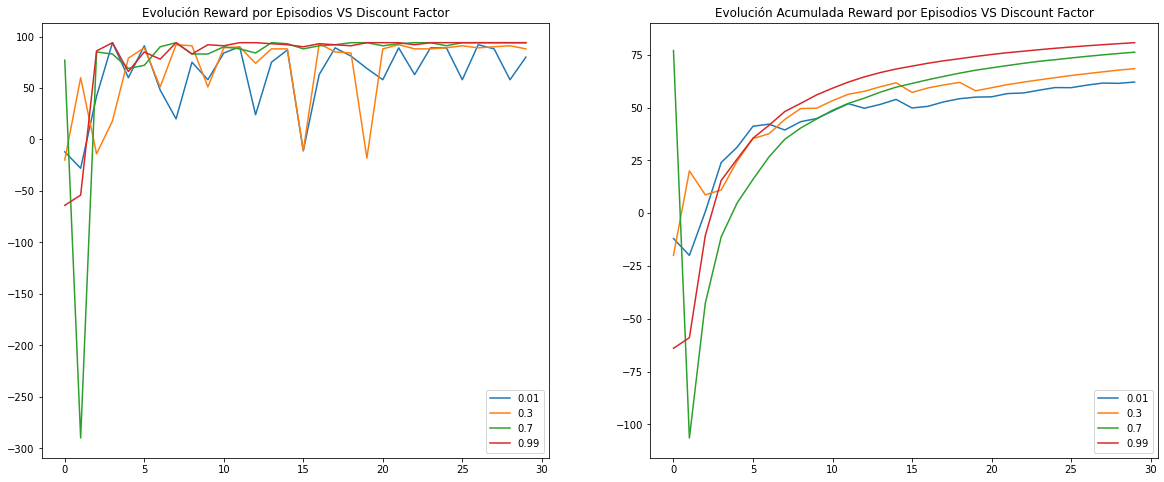

In [13]:
discount_factors = [0.01, 0.3, 0.7, 0.99]
experiments = []
for disfac in discount_factors:
    episodes_list, best_episode = run_agent(learner=SARSALearner,
                                            num_episodes=30,
                                            learning_rate=0.1,
                                            discount_factor=disfac,
                                            ratio_exploration=0.05)
    experiments.append({'Discount Factor': str(disfac),
                        'Rewards': [episode[2] for episode in episodes_list]})

plt.figure(figsize=(20, 8))
for experiment in experiments:
    plt.subplot(1, 2, 1)
    plt.title('Evolución Reward por Episodios VS Discount Factor')
    plt.plot(experiment['Rewards'], label=experiment['Discount Factor'])
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Evolución Acumulada Reward por Episodios VS Discount Factor')
    acum_avg_reward = (np.cumsum(experiment['Rewards']) / (np.arange(len(experiment['Rewards'])) + 1))[0:]
    plt.plot(acum_avg_reward, label=experiment['Discount Factor'])
    plt.legend(loc='lower right')

plt.show()

<hr>

*Este Notebook ha sido desarrollado por **Ricardo Moya García** y registrado en Safe Creative como ***Atribución-NoComercial-CompartirIgual***.*


<a href="https://www.safecreative.org/work/2005103928020" xmlns:cc="http://creativecommons.org/ns#" rel="cc:license"><img src="https://resources.safecreative.org/work/2005103928020/label/standard-72" style="border:0;" alt="Safe Creative #2005103928020"/></a>